In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

Now let’s load the dataset into the pandas dataframe.

In [56]:
data = pd.read_csv("all_stocks_5yr.csv")
print(data.shape)
print(data.sample(7))

(619040, 7)
              date    open      high     low   close    volume  Name
307093  2015-08-31   55.50   55.9000   55.15   55.29   2331925    IR
8350    2016-04-08  112.92  113.2300  111.85  112.83   1627345   ACN
327045  2017-04-20  133.14  133.1900  131.11  131.23   2697353   KMB
321747  2013-11-08   12.49   13.0200   12.45   13.02  11085731   KEY
260046  2017-11-27   30.69   30.9232   30.61   30.89   2376196    GT
213097  2016-03-21   48.50   48.6900   46.42   48.48   1553127  EXPD
397849  2013-06-28   30.85   31.4700   30.73   31.03   5697301   MYL


Since the given data consists of a date feature, this is more likely to be an ‘object’ data type.

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


Whenever we deal with the date or time feature, it should always be in the DateTime data type. Pandas library helps us convert the object date feature to the DateTime data type.

In [58]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


# Exploratory Data Analysis

EDA also known as Exploratory Data Analysis is a technique that is used to analyze the data through visualization and manipulation. For this project let us visualize the data of famous companies such as Nvidia, Google, Apple, Facebook, and so on.

First, let us consider a few companies and visualize the distribution of open and closed Stock prices through 5 years.

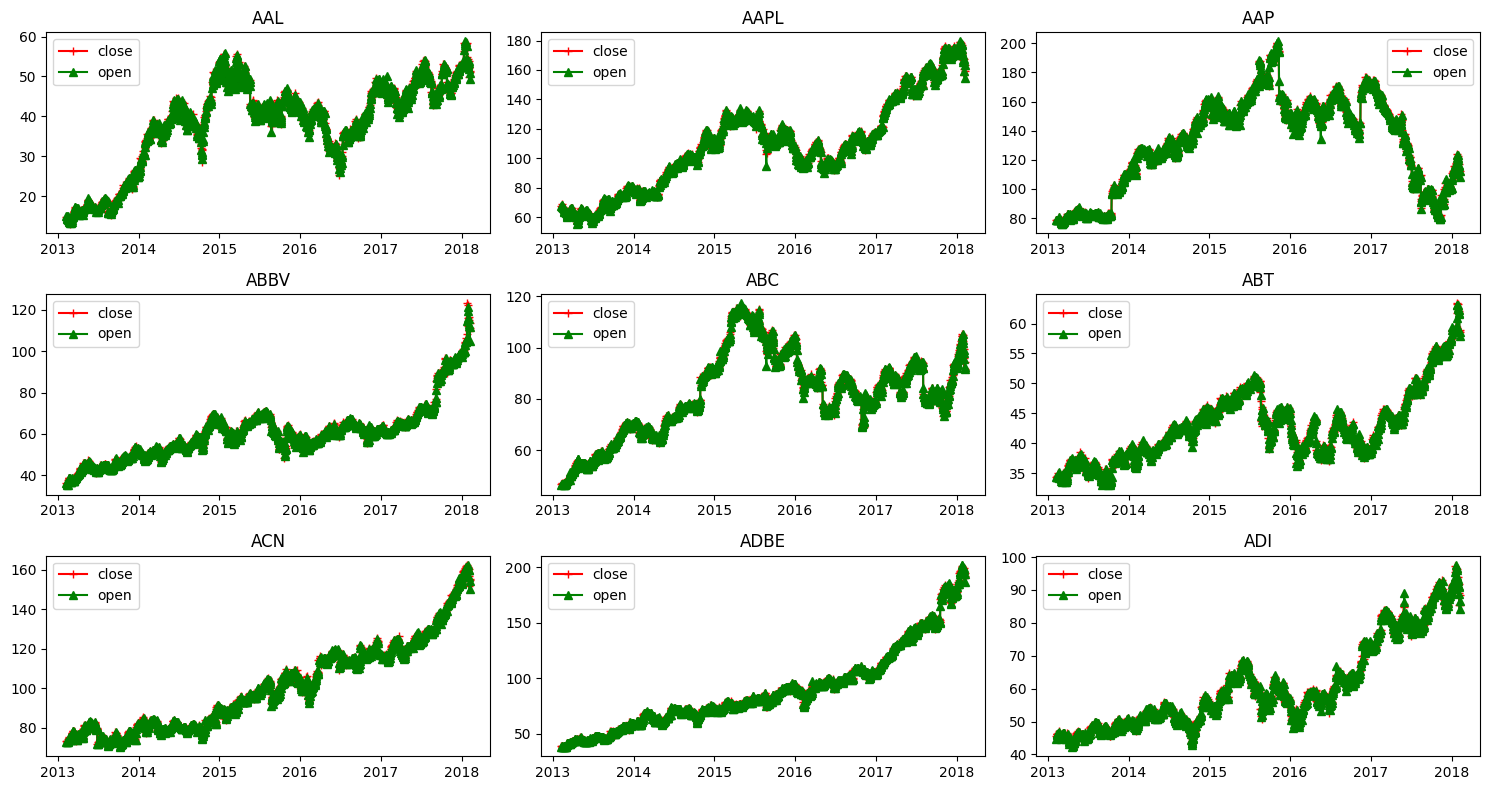

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'companies' is a list of company names, define it here
companies = ['AAL',
'AAPL',
'AAP',
'ABBV',
'ABC',
'ABT',
'ACN', 'ADBE' ,'ADI']

data['date'] = pd.to_datetime(data['date'])
# date vs open
# date vs close
plt.figure(figsize=(15, 8))
for index, company in enumerate(companies, 1):  # Now 'companies' is defined
    plt.subplot(3, 3, index)
    c = data[data['Name'] == company]
    plt.plot(c['date'], c['close'], c="r", label="close", marker="+")
    plt.plot(c['date'], c['open'], c="g", label="open", marker="^")
    plt.title(company)
    plt.legend()
    plt.tight_layout()

Now let’s plot the volume of trade for these 9 stocks as well as a function of time.

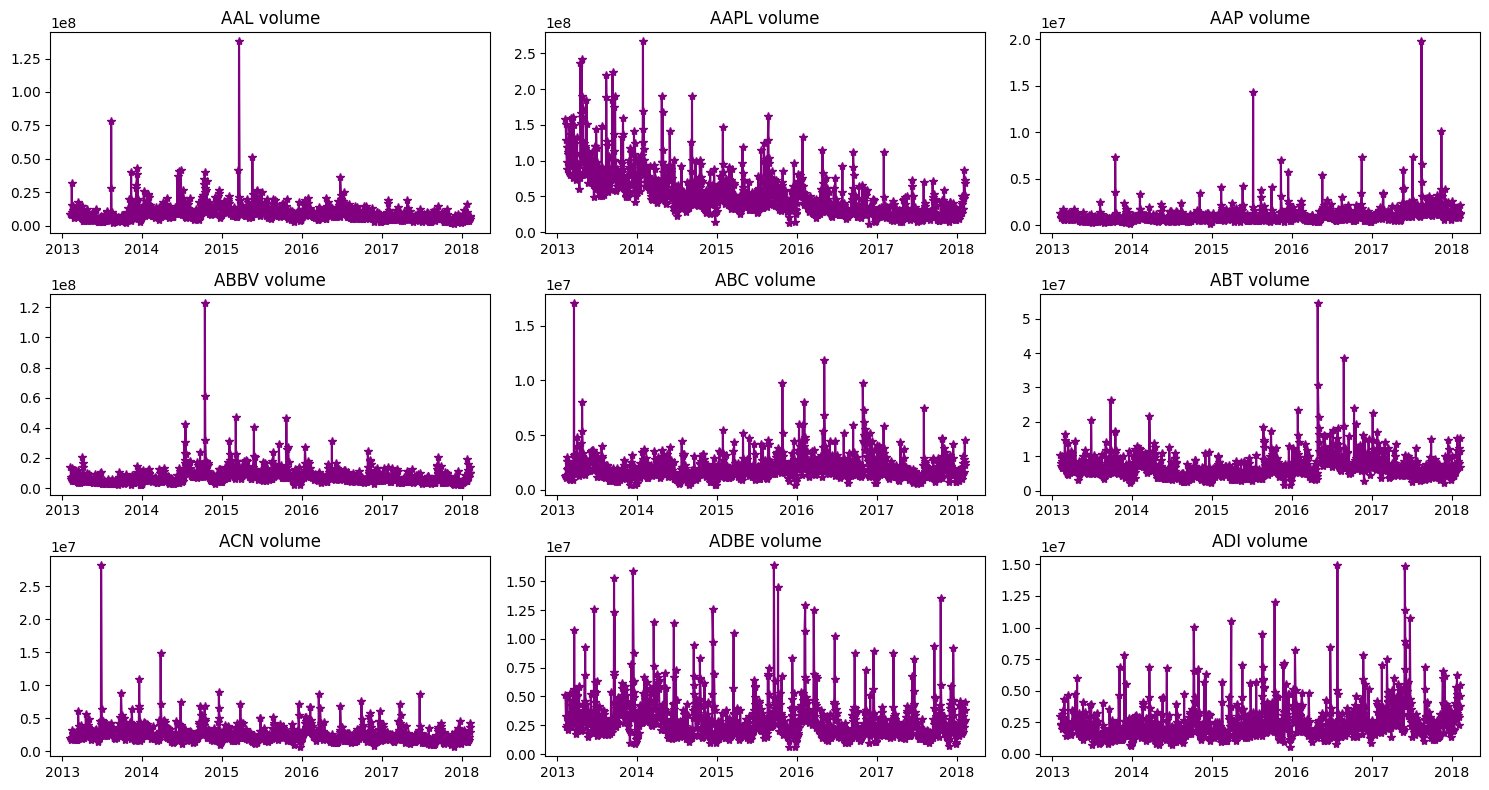

In [60]:
plt.figure(figsize=(15,8))
for index, company in enumerate(companies, 1):
  plt.subplot(3, 3 , index)
  c =data[data['Name'] == company]
  plt.plot(c['date'], c['volume'], c = 'purple', marker= '*')
  plt.title(f"{company} volume")
  plt.tight_layout()

Now let’s analyze the data for AAL Stocks from 2013 to 2018.

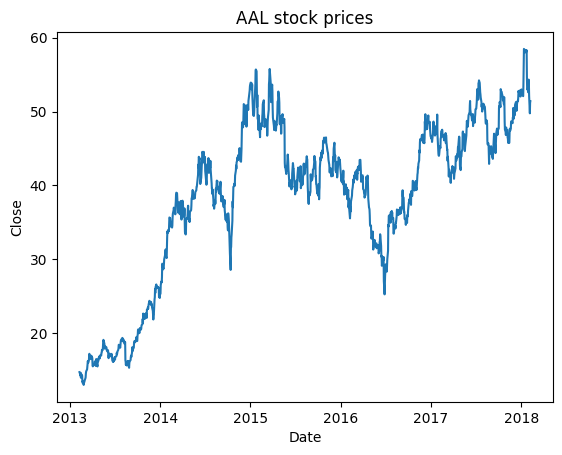

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime # Import the datetime module

AAL = data[data['Name'] == 'AAL']
prediction_range = AAL.loc[(AAL['date'] > datetime(2013,1,1))
                           & (AAL['date'] < datetime(2018,1,1))] # Align '&' with the start of the previous line
plt.plot(AAL['date'], AAL['close']) # Fix the plot function arguments
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("AAL stock prices")
plt.show()

Now let’s select a subset of the whole data as the training data so, that we will be left with a subset of the data for the validation part as well.

In [62]:
close_data = AAL.filter({'close'})
dataset = close_data.values
training = int (np.ceil(len(dataset)* .95))
print(training)

1197


Now we have the training data length, next applying scaling and preparing features and labels that are x_train and y_train.

In [63]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1 ))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range (60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))




# Build Gated RNN- LSTM network using TensorFlow

Using TensorFlow, we can easily create LSTM-gated RNN cells. LSTM is used in Recurrent Neural Networks for sequence models and time series data. LSTM is used to avoid the vanishing gradient issue which is widely occurred in training RNN. To stack multiple LSTM in TensorFlow it is mandatory to use return_sequences = True. Since our data is time series varying we apply no activation to the output layer and it remains as 1 node.

In [64]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))

model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 60, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

# Model Compilation and Training

While compiling a model we provide these three essential parameters:

1-


optimizer – This is the method that helps to optimize the cost function by using gradient descent.




2-



loss – The loss function by which we monitor whether the model is improving with training or not.



3-




 metrics – This helps to evaluate the model by predicting the training and the validation data.

For predicting we require testing data, so we first create the testing data and then proceed with the model prediction.

In [65]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test =  dataset[training:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])


x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# predict the testing data

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test)** 2 ))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
MSE 1689.0934961130229
RMSE 41.09858265333517


Now that we have predicted the testing data, let us visualize the final results.

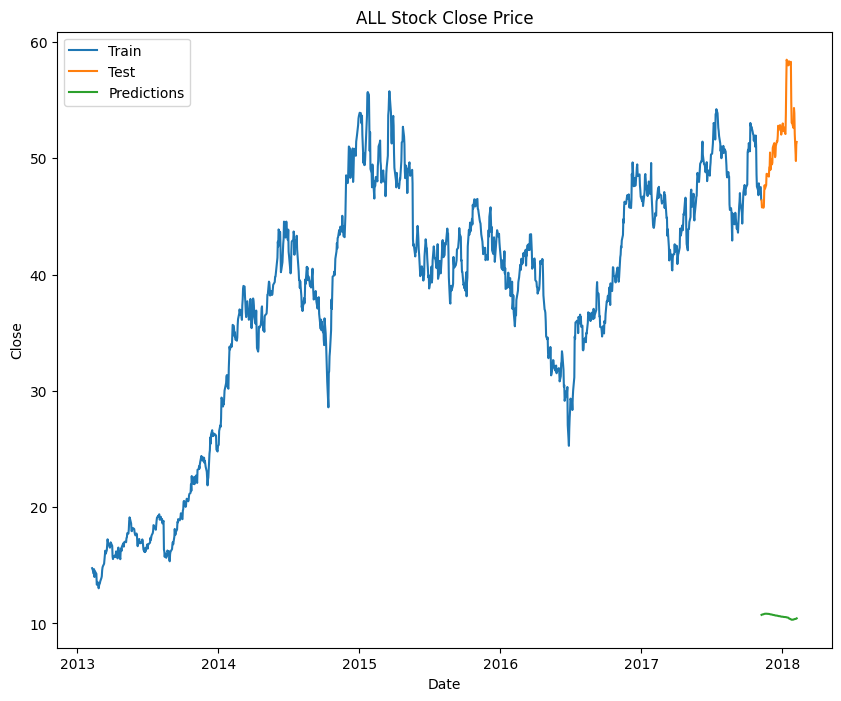

In [68]:
import matplotlib.pyplot as plt
train = AAL[:training]
test = AAL[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot(train['date'], train['close'])
plt.plot(test['date'], test[['close', 'Predictions']])
plt.title('ALL Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])